# **Анализ доходностей облигаций США методом главных компонент**

In [3]:
install.packages('randtests')
install.packages('fitdistrplus')
install.packages('zoo')
install.packages("xts", repos="http://cloud.r-project.org")

library(randtests)
library(fitdistrplus)
library(zoo)
library(xts)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: MASS

Loading required package: survival


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [8]:
rates <- read.csv("./Rates.csv",header = TRUE )
head(rates)

,Date,X1.Mo,X2.Mo,X3.Mo,X6.Mo,X1.Yr,X2.Yr,X3.Yr,X5.Yr,X7.Yr,X10.Yr,X20.Yr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01/03/22,0.05,0.06,0.08,0.22,0.40,0.78,1.04,1.37,1.55,1.63,2.05
2,01/04/22,0.06,0.05,0.08,0.22,0.38,0.77,1.02,1.37,1.57,1.66,2.10
3,01/05/22,0.05,0.06,0.09,0.22,0.41,0.83,1.10,1.43,1.62,1.71,2.12
4,01/06/22,0.04,0.05,0.10,0.23,0.45,0.88,1.15,1.47,1.66,1.73,2.12
5,01/07/22,0.05,0.05,0.10,0.24,0.43,0.87,1.17,1.50,1.69,1.76,2.15
6,01/10/22,0.05,0.06,0.13,0.28,0.46,0.92,1.21,1.53,1.71,1.78,2.15


In [11]:
(ncol <- dim(rates)[2])
(nrow <- dim(rates)[1])

dates <- as.Date(rates[,1], "%m/%d/%y")
head(dates)

[1] 12

[1] 310

[1] "2022-01-03" "2022-01-04" "2022-01-05" "2022-01-06" "2022-01-07"
[6] "2022-01-10"

           X1.Mo X2.Mo X3.Mo X6.Mo X1.Yr X2.Yr X3.Yr X5.Yr X7.Yr X10.Yr X20.Yr
2022-01-03  0.05  0.06  0.08  0.22  0.40  0.78  1.04  1.37  1.55   1.63   2.05
2022-01-04  0.06  0.05  0.08  0.22  0.38  0.77  1.02  1.37  1.57   1.66   2.10
2022-01-05  0.05  0.06  0.09  0.22  0.41  0.83  1.10  1.43  1.62   1.71   2.12
2022-01-06  0.04  0.05  0.10  0.23  0.45  0.88  1.15  1.47  1.66   1.73   2.12
2022-01-07  0.05  0.05  0.10  0.24  0.43  0.87  1.17  1.50  1.69   1.76   2.15
2022-01-10  0.05  0.06  0.13  0.28  0.46  0.92  1.21  1.53  1.71   1.78   2.15

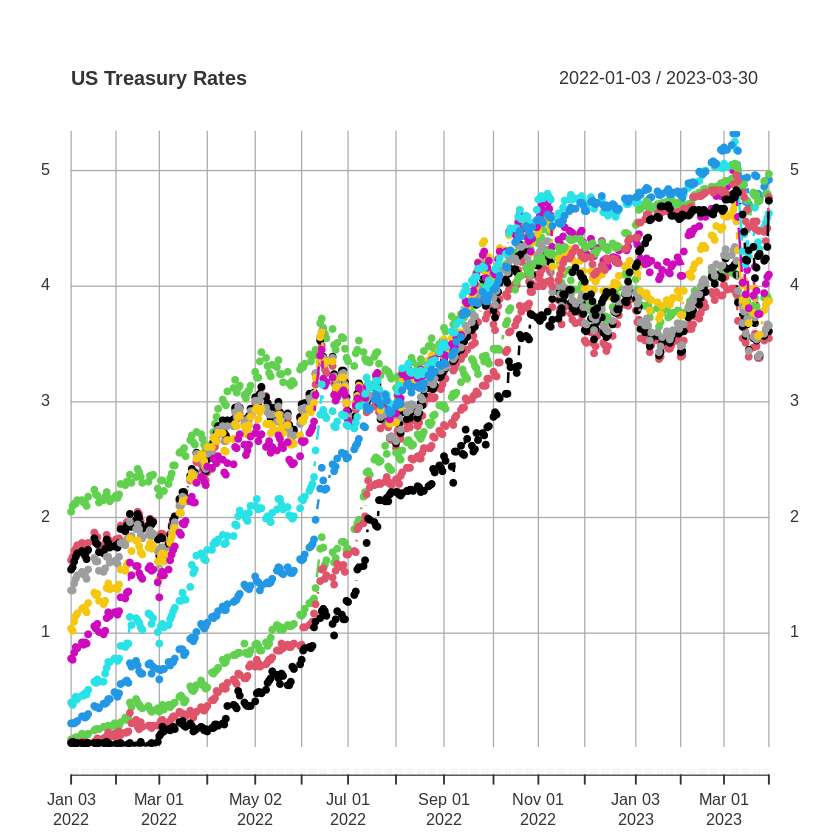

In [12]:
#график доходностей
rates.xts <- as.xts(rates[2:ncol], order.by = dates)
head(rates.xts)

plot(rates.xts,type = 'b',pch =20,main = "US Treasury Rates")

In [13]:
#Применяем метод главных компонент
pca <- prcomp(rates.xts, scale = FALSE)
summary(pca)

Importance of components:
                         PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     4.219 0.77959 0.17049 0.13189 0.06922 0.05065 0.04319
Proportion of Variance 0.964 0.03292 0.00157 0.00094 0.00026 0.00014 0.00010
Cumulative Proportion  0.964 0.99688 0.99845 0.99940 0.99965 0.99979 0.99989
                           PC8     PC9    PC10     PC11
Standard deviation     0.03433 0.02379 0.01206 0.007176
Proportion of Variance 0.00006 0.00003 0.00001 0.000000
Cumulative Proportion  0.99996 0.99999 1.00000 1.000000

Видим, что только первый фактор главный фактор объясняет более 95% всей дисперсии

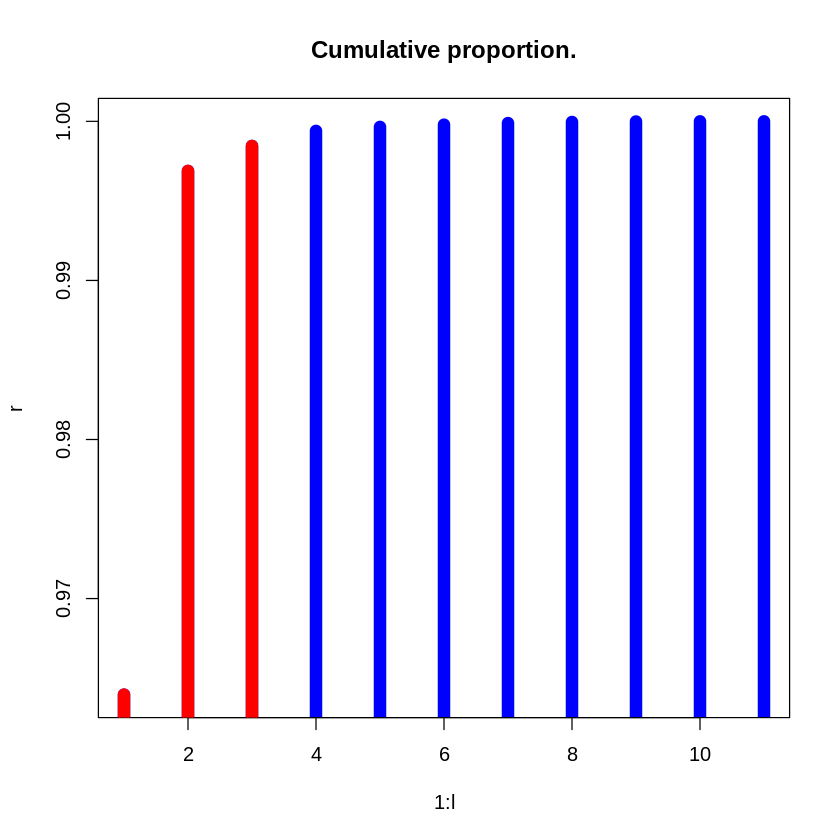

In [14]:
#Построим график важности (накопленной меры информативности) каждой главной компоненты
ss <- summary(pca)
his <- ss$importance[3,]
l <- length(his)
his[4:l]<- NA
r <- as.matrix(cbind(ss$importance[3,],his))

mp <- matplot(1:l,r,type = 'h',lty = 1, lwd = 10,main = "Cumulative proportion.", col = c("blue",'red')) # default
abline(h = 0.8,col = 'black')

Только в первых трех значениях информативности есть изменения, а начиная с 4-ой мера информативности практически не изменяется, имея значения около 100%. В силу этого первые три фактора среди участников рынка получили название shift,twist,butterfly.

In [15]:
tot <- ss$importance[2,]
rownames(ss$rotation)

[1] "X1.Mo"  "X2.Mo"  "X3.Mo"  "X6.Mo"  "X1.Yr"  "X2.Yr"  "X3.Yr"  "X5.Yr" 
 [9] "X7.Yr"  "X10.Yr" "X20.Yr"

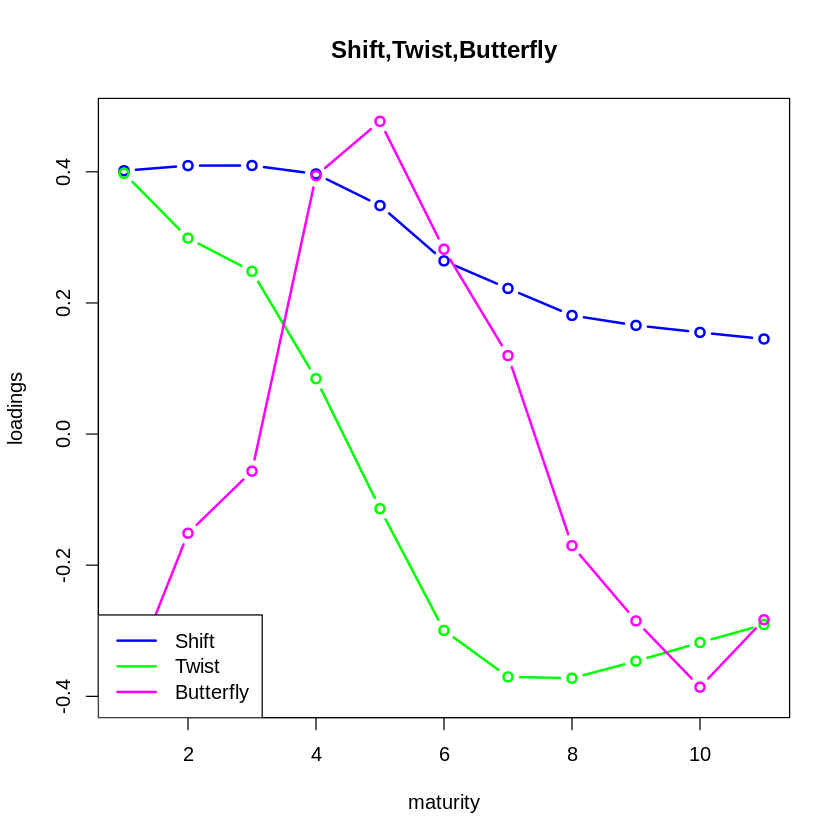

In [16]:
matplot(cbind(ss$rotation[,1],ss$rotation[,2],ss$rotation[,3]),type = 'b',pch=21,lwd = 2,
col = c("blue","green","magenta"),main= "Shift,Twist,Butterfly",ylab = "loadings",xlab="maturity",lty=1 )
legend("bottomleft",c("Shift","Twist","Butterfly"),lty=c(1,1,1),lwd = 2,col = c("blue","green","magenta"))

Теперь посчитаем и построим графики доходностей трёх главных факторов

In [1]:
scores <- function(ldata,pca,number)
{
  cdata <- ldata
  m <- dim(ldata)[2]
  for (i in 1:m)
    cdata[,i] <- ldata[,i] - pca$center[i]
  loads <- pca$rotation[,1:number]
  cdata <- as.matrix(cdata)
  f <- cdata %*% loads
  return (f)
}

In [2]:
install.packages('outliers')
  library('outliers')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘outliers’


The following object is masked _by_ ‘.GlobalEnv’:

    scores




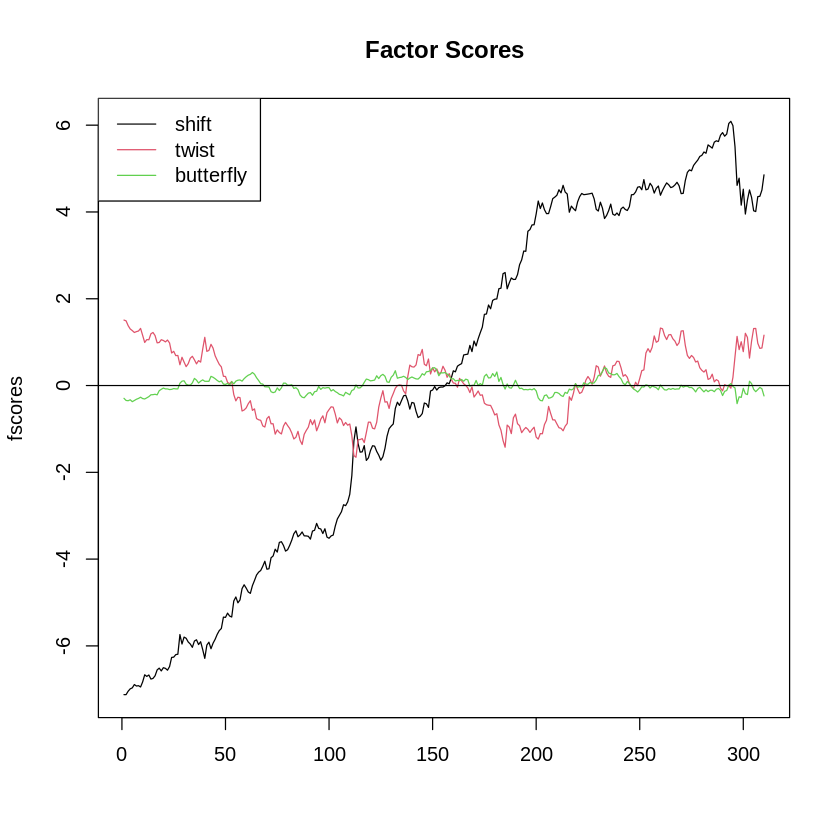

In [19]:
fscores <- scores(rates.xts, ss, 3)
matplot(fscores,type = 'l',lty = 1, col = 1:3,main = 'Factor Scores')
legend('topleft',c('shift','twist','butterfly'),col = 1:3,lty = 1)
abline(h=0)

**Восстановим доходности по факторам и сравним оригинальные и восстановленные доходности последнего дня**

In [17]:
restoreData<- function(fscores,loadings,center)
{
  npca <- dim(fscores)[2]
  myeigen <- t(loadings[,1:npca])
  rest <- fscores %*%myeigen
  m <- length(center)
  if (m == dim(rest)[2])
  {
    for (i in 1:m)
    rest[,i] <- rest[,i]+center[i]
  }
  return(rest)
}

In [20]:
rest <- restoreData(fscores,ss$rotation,ss$center)
ndays <- dim(fscores)[1]
head(rest)

,X1.Mo,X2.Mo,X3.Mo,X6.Mo,X1.Yr,X2.Yr,X3.Yr,X5.Yr,X7.Yr,X10.Yr,X20.Yr
2022-01-03,0.09281967,0.03534993,0.08883291,0.1714099,0.3880640,0.8377427,1.075028,1.357428,1.531173,1.617441,2.029502
2022-01-04,0.10570124,0.03797273,0.08773132,0.1512047,0.3672076,0.8294984,1.075862,1.372352,1.551221,1.641899,2.048471
2022-01-05,0.09561869,0.03780840,0.09257178,0.1701590,0.4038203,0.8814178,1.133450,1.428900,1.604479,1.691849,2.093904
2022-01-06,0.07845606,0.03411087,0.09487208,0.1942753,0.4423290,0.9252150,1.176783,1.463714,1.633923,1.716289,2.117956
2022-01-07,0.08999105,0.03872333,0.09723486,0.1827234,0.4334408,0.9298707,1.190233,1.488997,1.662929,1.748419,2.144347
2022-01-10,0.09251427,0.05288529,0.11621095,0.2201584,0.4781292,0.9709202,1.226751,1.514558,1.683061,1.763735,2.160490


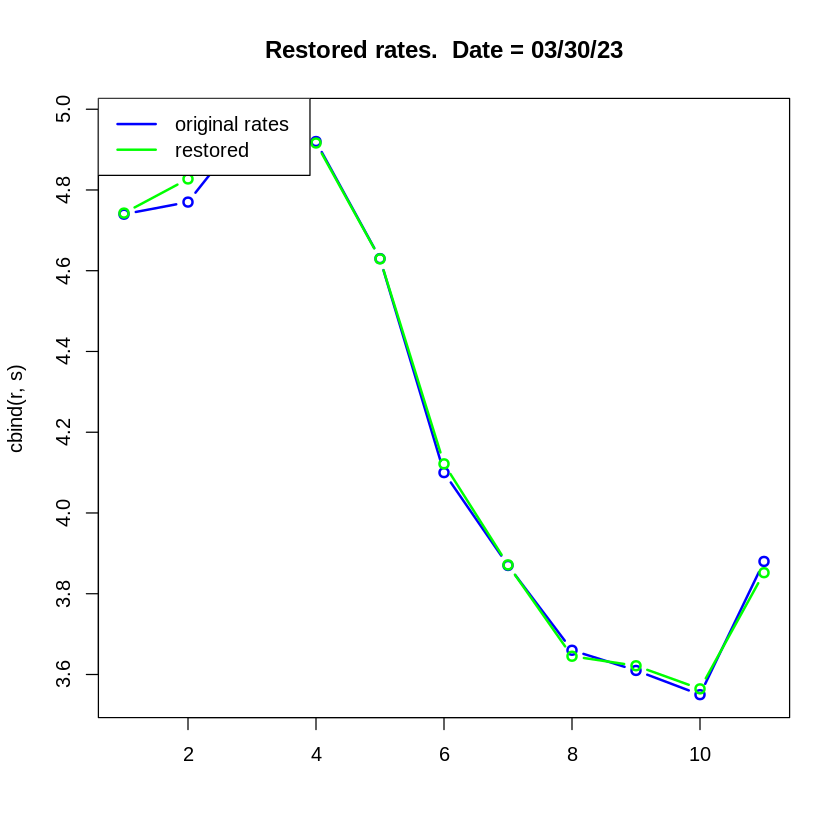

In [21]:
r <- unlist(rates.xts[ndays,])
r <- as.matrix(r,ncol = 1)
r <- t(r)
s <- as.matrix(rest[ndays,],ncol = 1)
title <- paste('Restored rates.',' Date =',rates[ndays,1])
matplot(cbind(r,s),type ='b',pch=21,lwd = 2,main = title,col = c('blue','green'),lty = 1)
legend('topleft',c('original rates','restored'),lty=1,lwd=2,col=c('blue','green'))

**Вычислим цену портфеля из облигаций в количестве (15,15,15,200,15,20,20,10,10,10,10) со сроками до окончания 1 Mo,2 Mo 3 Mo, 6 Mo, 1 Yr, 2 Yr ,3 Yr, 5 Yr, 7 Yr, 10 Yr, 20 Yr, если каждая облигация имеет купон 3% и выплачивает купонный доход 2 раза в год. для последнего дня заданного года по оригинальным рейтам и восстановленным по shift,twist,butterfly.**

In [22]:
install.packages("FinAna")
library(FinAna)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [23]:
get_balance<- function(yield)
{
  beta <- c(15, 15, 15, 200, 15, 20, 20, 10, 10, 10, 10)
  tau <- c(1 / 12, 2 / 12, 3 / 12, 6 / 12, 1, 2, 3, 5, 7, 10, 20)
  coupon <- 0.03
  m <- 2 # 2 раза в год
  nom <- 1000 # номинал

  balance = 0
  for (i in 1:11) {
    balance <- balance + beta[i] * bond.price(nom,coupon,tau[i],yield[i],m)
  }

  return (balance)
}

yield_orig <- r # реальная рыночная доходность 
yield_rest <- s # восстановленная по shift, twist, butterfly
get_balance(yield_orig)
get_balance(yield_rest)

[1] 91379.54

[1] 91415.7